# Data Science - Project
# Predicting which team is more likely to win under certain circumstances

In [692]:
# importing neccesary libraries
import numpy as np
import pandas as pd
from datetime import datetime as dt
import itertools
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sklearn.linear_model import LinearRegression
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.pinimg.com/originals/e5/ac/e9/e5ace9d111b004b7cef61afe8d3f4c7a.jpg")

<p> The purpose of this project is to gain basic knowledge of how to use different machine learning techniques to predict certain events. </p>
<p> Therefore, before using different machine learning algorithms, first we need to do the following steps: </p>
    <li> Clean the data </li>
    <li> Visualise the data </li>
    <li> Create the model </li>
    <li> Train the model with certain features </li>
    <li> Predict </li>
 

## Data Cleaning

In [693]:
# Read data from .csv files 

loc = "voetbal_new/"

raw_cards_file = pd.read_csv (loc + '_cards.csv')
raw_goals_file = pd.read_csv (loc + '_goals.csv')
raw_matches_file = pd.read_csv (loc + '_matches.csv')
raw_players_file = pd.read_csv (loc + '_players.csv')


##### Helper functions

In [694]:
# function to remove duplicates 
def Duplicates(rawName , colName: str, previousName: str, newName: str ):
        if colName == "club":
                rawName["home"].replace({previousName: newName }, inplace=True)
                rawName["away"].replace({previousName: newName }, inplace=True)
                rawName["team"].replace({previousName: newName }, inplace=True)
        elif colName == "match":
                rawName["home"].replace({previousName: newName }, inplace=True)
                rawName["away"].replace({previousName: newName }, inplace=True)
        elif colName == "card": 
                rawName["type"].replace({previousName: newName }, inplace=True)
        else:
                print("nothing")

In [695]:
# function used to get the last season
def toOneSeason(season):
    return season[5:len(season)]

In [696]:
def assist(value):
    if pd.notna(value):
        return 1
    else:
        return 0

In [697]:
def firstGoal(col: str):
    return raw_goals_file[col].loc[(raw_goals_file['new_score']== '1:0') | (raw_goals_file['new_score'] == '0:1')]

In [698]:
def typeGoal(value):
    if pd.notna(value):
        return value
    else:
        return "no type"

In [699]:
def searchTeam(teams, teamName):
    for (k,i) in teams.items():
        if k == teamName:
            return (k, i)

In [700]:
# Function used for the matches:
# 1 means that home team is the winner 
# -1 means that home team is the loser
# 0 means that home team tied with the away team
def ClassifyMatches(row):
    if(row.home_score > row.away_score):
        return 1
    elif(row.home_score < row.away_score):
        return -1
    else:
        return 0

##### Goals

In [701]:
Duplicates(raw_goals_file, "club", "afc-ajax", "ajax-amsterdam")
Duplicates(raw_goals_file, "club", "feyenoord", "feyenoord-rotterdam")
Duplicates(raw_goals_file, "club", "vitesse", "vitesse-arnheim")
Duplicates(raw_goals_file, "club", "willem-ii", "willem-ii-tilburg")
Duplicates(raw_goals_file, "club", "mvv", "mvv-maastricht")
Duplicates(raw_goals_file, "club", "sbv-excelsior", "excelsior-rotterdam")
Duplicates(raw_goals_file, "club", "sc-cambuur", "cambuur-leeuwarden")
Duplicates(raw_goals_file, "club", "fc-twente", "twente-enschede")
Duplicates(raw_goals_file, "club", "go-ahead-eagles_2", "go-ahead-eagles")

raw_goals_file["type"].replace({"Schot met rechts": "Right shot"}, inplace=True)
raw_goals_file["type"].replace({"Kopbal": "Header"}, inplace=True)
raw_goals_file["type"].replace({"Schot met links": "Left shot"}, inplace=True)
raw_goals_file["type"].replace({"Eigen goal": "Own goal"}, inplace=True)
raw_goals_file["type"].replace({"dir. vrije trap": "rest"}, inplace=True) # ind. vrije trap -> rest
raw_goals_file["type"].replace({"ind. vrije trap": "rest"}, inplace=True) # ind. vrije trap -> rest
raw_goals_file["type"].replace({"Omhaal": "rest"}, inplace=True)  # Omhaal -> rest
raw_goals_file["type"].replace({"Hakbal": "rest"}, inplace=True)  # Hakbal -> rest



In [702]:
groubBy_typeGoal = raw_goals_file['type'].value_counts()

In [703]:
df_goals = pd.DataFrame()

season = firstGoal("saison")
round =  firstGoal("round")
home =  firstGoal("home")
away = firstGoal("away")
minute = firstGoal("minute")
first_goal = firstGoal("new_score")


df_goals['season'] = season
df_goals['round'] = round
df_goals['home'] = home
df_goals['away'] = away
df_goals['minute'] = minute
df_goals['first_goal'] = first_goal

df_goals.loc[(df_goals["first_goal"] == "1:0"), "first_goal"] = "home"
df_goals.loc[(df_goals["first_goal"] == "0:1"), "first_goal"] = "away"

df_goals['season'] = df_goals['season'].apply(toOneSeason)
df_goals['season'] = df_goals['season'].astype(int)
df_goals.dropna()

,season,round,home,away,minute,first_goal
0,1957,16,ajax-amsterdam,bvc-amsterdam,27,home
5,1957,27,ajax-amsterdam,fc-den-bosch,20,home
6,1957,15,ajax-amsterdam,fc-utrecht,28,home
9,1957,25,ajax-amsterdam,feyenoord-rotterdam,62,home
10,1957,13,ajax-amsterdam,fortuna-54,20,away
...,...,...,...,...,...,...
60972,2022,7,willem-ii-tilburg,psv-eindhoven,20,home
60975,2022,21,willem-ii-tilburg,rkc-waalwijk,8,home
60979,2022,16,willem-ii-tilburg,cambuur-leeuwarden,49,away
60983,2022,12,willem-ii-tilburg,sparta-rotterdam,17,away


#### Matches

In [704]:
Duplicates(raw_matches_file, "match", "afc-ajax", "ajax-amsterdam")
Duplicates(raw_matches_file, "match", "feyenoord", "feyenoord-rotterdam")
Duplicates(raw_matches_file, "match", "vitesse", "vitesse-arnheim")
Duplicates(raw_matches_file, "match", "willem-ii", "willem-ii-tilburg")
Duplicates(raw_matches_file, "match", "mvv", "mvv-maastricht")
Duplicates(raw_matches_file, "match", "sbv-excelsior", "excelsior-rotterdam")
Duplicates(raw_matches_file, "match", "sc-cambuur", "cambuur-leeuwarden")
Duplicates(raw_matches_file, "match", "fc-twente", "twente-enschede")
Duplicates(raw_matches_file, "match", "go-ahead-eagles_2", "go-ahead-eagles")
raw_matches_file["away_score"].replace({"2 Toeg.": "0"}, inplace=True)
raw_matches_file["away_score"].replace({"-": "0"}, inplace=True)
raw_matches_file["away_score"].replace({"- niet gespeeld": "0"}, inplace=True)
raw_matches_file["home_score"].replace({"-": "0"}, inplace=True)
raw_matches_file['away_score'] = raw_matches_file['away_score'].astype(int)
raw_matches_file['home_score'] = raw_matches_file['home_score'].astype(int)

In [705]:
df_matches = pd.DataFrame()
season = raw_matches_file["saison"]
round =  raw_matches_file["round"]
home =  raw_matches_file["home"]
away = raw_matches_file["away"]
home_score = raw_matches_file["home_score"]
away_score = raw_matches_file["away_score"]


df_matches['season'] = season
df_matches['round'] = round
df_matches['home'] = home
df_matches['away'] = away
df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches['winning_team'] = df_matches.apply(lambda row: ClassifyMatches(row),axis=1)
df_matches['total_goals'] = home_score + away_score



df_matches['season'] = df_matches['season'].apply(toOneSeason)
df_matches['season'] = df_matches['season'].astype(int)

df_matches[(df_matches['home_score'] != '-') &
           (df_matches['away_score'] != '-')]

df_matches



,season,round,home,away,home_score,away_score,winning_team,total_goals
0,1957,16,ajax-amsterdam,bvc-amsterdam,2,3,-1,5
1,1957,27,ajax-amsterdam,fc-den-bosch,1,0,1,1
2,1957,15,ajax-amsterdam,fc-utrecht,1,2,-1,3
3,1957,25,ajax-amsterdam,feyenoord-rotterdam,1,0,1,1
4,1957,13,ajax-amsterdam,fortuna-54,0,2,-1,2
...,...,...,...,...,...,...,...,...
19925,2022,21,willem-ii-tilburg,rkc-waalwijk,3,1,1,4
19926,2022,16,willem-ii-tilburg,cambuur-leeuwarden,1,3,-1,4
19927,2022,25,willem-ii-tilburg,sc-heerenveen,0,0,0,0
19928,2022,12,willem-ii-tilburg,sparta-rotterdam,0,3,-1,3


#### Cards

In [706]:
Duplicates(raw_cards_file, "club", "afc-ajax", "ajax-amsterdam")
Duplicates(raw_cards_file, "club", "willem-ii", "willem-ii-tilburg")
Duplicates(raw_cards_file, "club", "mvv", "mvv-maastricht")
Duplicates(raw_cards_file, "club", "vitesse", "vitesse-arnhem")
Duplicates(raw_cards_file, "club", "sc-cambuur", "cambuur-leeuwarden")
Duplicates(raw_cards_file, "club", "feyenoord", "feyenoord-rotterdam")
Duplicates(raw_cards_file, "club", "go-ahead-eagles_2", "go-ahead-eagles")

Duplicates(raw_cards_file, "card", "rode kaart", "red-card")
Duplicates(raw_cards_file, "card", "rode", "red-card")
Duplicates(raw_cards_file, "card", "kaartrode", "red-card")
Duplicates(raw_cards_file, "card", "gele kaart", "yellow-card")
Duplicates(raw_cards_file, "card", "gele", "yellow-card")
Duplicates(raw_cards_file, "card", "kaartgele", "yellow-card")
Duplicates(raw_cards_file, "card", "geelrode kaart", "red-card")
raw_cards_file.drop(columns=['player','type'])
raw_cards_file['saison'] = raw_cards_file['saison'].apply(toOneSeason)
raw_cards_file['saison'] = raw_cards_file['saison'].astype(int)


df_cards = pd.DataFrame()
season = raw_cards_file['saison']
round = raw_cards_file['round']
home = raw_cards_file['home']
away = raw_cards_file['away']
team = raw_cards_file['team']
type = raw_cards_file['type']
yellowCards = raw_cards_file['type']
redCards = raw_cards_file['type']
home_cards = raw_cards_file['type']
away_cards = raw_cards_file['type']



df_cards['season'] =  season
df_cards['round'] =  round
df_cards['home'] =  home
df_cards['away'] =  away
df_cards['team'] =  team
df_cards['type'] =  type
df_cards['yellowCards'] =  yellowCards
df_cards['redCards'] =  redCards
df_cards['home_cards'] =  home_cards
df_cards['away_cards'] =  away_cards
df_cards["yellowCards"].replace({"red-card": 0, "yellow-card": 1 }, inplace=True)
df_cards["redCards"].replace({"red-card": 1, "yellow-card": 0 }, inplace=True)

df_cards.loc[(df_cards["home_cards"] == "red-card") & (df_cards["home"] == df_cards["team"]), "home_cards"] = "red"
df_cards.loc[(df_cards["away_cards"] == "red-card") & (df_cards["away"] == df_cards["team"]), "away_cards"] = "red"
df_cards.loc[(df_cards["home_cards"] == "yellow-card") & (df_cards["home"] == df_cards["team"]), "home_cards"] = "yellow"
df_cards.loc[(df_cards["away_cards"] == "yellow-card") & (df_cards["away"] == df_cards["team"]), "away_cards"] = "yellow"
df_cards["home_cards"].replace({"red-card": 0, "yellow-card": 0, "yellow": 1,  "red": 2 }, inplace=True)
df_cards["away_cards"].replace({"red-card": 0, "yellow-card": 0, "yellow": 1,  "red": 2 }, inplace=True)

df_cards

,season,round,home,away,team,type,yellowCards,redCards,home_cards,away_cards
0,1963,8,heracles-almelo,fc-twente,fc-twente,red-card,0,1,0,2
1,1972,5,fc-groningen,ajax-amsterdam,fc-groningen,red-card,0,1,2,0
2,1972,5,fc-groningen,ajax-amsterdam,ajax-amsterdam,red-card,0,1,0,2
3,1973,34,ajax-amsterdam,az-alkmaar,ajax-amsterdam,yellow-card,1,0,1,0
4,1973,34,ajax-amsterdam,az-alkmaar,az-alkmaar,yellow-card,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
32412,2022,12,willem-ii-tilburg,sparta-rotterdam,sparta-rotterdam,yellow-card,1,0,0,1
32413,2022,30,willem-ii-tilburg,vitesse-arnhem,vitesse-arnhem,yellow-card,1,0,0,1
32414,2022,30,willem-ii-tilburg,vitesse-arnhem,vitesse-arnhem,yellow-card,1,0,0,1
32415,2022,30,willem-ii-tilburg,vitesse-arnhem,vitesse-arnhem,yellow-card,1,0,0,1


<p> Adding new columns to see how many yellow cards/ red cards did the home/away team get in a match </p>

In [707]:
df_cards_new = pd.DataFrame()
season = df_cards['season']
round = df_cards['round']
home = df_cards['home']
away = df_cards['away']
team = df_cards['team']
type = df_cards['type']
yellowCards = df_cards['yellowCards']
redCards = df_cards['redCards']
home_cards = df_cards['home_cards']
away_cards = df_cards['away_cards']


df_cards_new['season'] =  season
df_cards_new['round'] =  round
df_cards_new['home'] =  home
df_cards_new['away'] =  away
df_cards_new['team'] =  team
df_cards_new['type'] =  type
df_cards_new['yellowCards'] =  yellowCards
df_cards_new['redCards'] =  redCards
df_cards_new['yellow_card_home'] =  home_cards
df_cards_new['yellow_card_away'] =  away_cards
df_cards_new['red_card_home'] =  home_cards
df_cards_new['red_card_away'] =  away_cards

df_cards_new["yellow_card_home"].replace({2: 0, 1: 1, 0: 0}, inplace=True)
df_cards_new["yellow_card_away"].replace({2: 0, 1: 1, 0: 0}, inplace=True)
df_cards_new["red_card_home"].replace({2: 1, 1: 0, 0: 0}, inplace=True)
df_cards_new["red_card_away"].replace({2: 1, 1: 0, 0: 0}, inplace=True)

df_cards_new

,season,round,home,away,team,type,yellowCards,redCards,yellow_card_home,yellow_card_away,red_card_home,red_card_away
0,1963,8,heracles-almelo,fc-twente,fc-twente,red-card,0,1,0,0,0,1
1,1972,5,fc-groningen,ajax-amsterdam,fc-groningen,red-card,0,1,0,0,1,0
2,1972,5,fc-groningen,ajax-amsterdam,ajax-amsterdam,red-card,0,1,0,0,0,1
3,1973,34,ajax-amsterdam,az-alkmaar,ajax-amsterdam,yellow-card,1,0,1,0,0,0
4,1973,34,ajax-amsterdam,az-alkmaar,az-alkmaar,yellow-card,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32412,2022,12,willem-ii-tilburg,sparta-rotterdam,sparta-rotterdam,yellow-card,1,0,0,1,0,0
32413,2022,30,willem-ii-tilburg,vitesse-arnhem,vitesse-arnhem,yellow-card,1,0,0,1,0,0
32414,2022,30,willem-ii-tilburg,vitesse-arnhem,vitesse-arnhem,yellow-card,1,0,0,1,0,0
32415,2022,30,willem-ii-tilburg,vitesse-arnhem,vitesse-arnhem,yellow-card,1,0,0,1,0,0


In [708]:
groupByAwayYellowCard = df_cards_new.groupby(['season', 'round','home', 'away'], as_index=False).agg(yellowCards = ('yellowCards', 'sum'), 
                                                                                redCards = ('redCards', 'sum'),
                                                                                yellowCardHome = ('yellow_card_home', 'sum'),
                                                                                yellowCardAway = ('yellow_card_away', 'sum'),
                                                                                redCardHome = ('red_card_home', 'sum'),
                                                                                redCardAway = ('red_card_away', 'sum'))
groupByAwayYellowCard

,season,round,home,away,yellowCards,redCards,yellowCardHome,yellowCardAway,redCardHome,redCardAway
0,1963,8,heracles-almelo,fc-twente,0,1,0,0,0,1
1,1972,5,fc-groningen,ajax-amsterdam,0,2,0,0,1,1
2,1973,1,ado-den-haag,sparta-rotterdam,2,0,0,2,0,0
3,1973,1,feyenoord-rotterdam,nec-nijmegen,2,0,1,1,0,0
4,1973,1,nac-breda,go-ahead-eagles,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
11166,2022,30,fc-twente,sparta-rotterdam,3,0,0,3,0,0
11167,2022,30,feyenoord-rotterdam,fc-utrecht,3,0,1,2,0,0
11168,2022,30,nec-nijmegen,ajax-amsterdam,2,0,0,2,0,0
11169,2022,30,rkc-waalwijk,pec-zwolle,3,0,2,1,0,0


#### Merge "Goals" and "Matches"

In [709]:
df_merge_goals= pd.merge(df_goals,df_matches,how='inner',left_on=['season','round','home', 'away'],right_on=['season','round','home', 'away'])
df_merge_goals["away_score"].replace({"2 Toeg.": 0}, inplace=True)
df_merge_goals['home_score'] = df_merge_goals['home_score'].astype(int)
df_merge_goals['away_score'] = df_merge_goals['away_score'].astype(int)
df_merge_goals.head(10)

,season,round,home,away,minute,first_goal,home_score,away_score,winning_team,total_goals
0,1957,16,ajax-amsterdam,bvc-amsterdam,27,home,2,3,-1,5
1,1957,27,ajax-amsterdam,fc-den-bosch,20,home,1,0,1,1
2,1957,15,ajax-amsterdam,fc-utrecht,28,home,1,2,-1,3
3,1957,25,ajax-amsterdam,feyenoord-rotterdam,62,home,1,0,1,1
4,1957,13,ajax-amsterdam,fortuna-54,20,away,0,2,-1,2
5,1957,3,ajax-amsterdam,fc-groningen,2,home,4,2,1,6
6,1957,5,ajax-amsterdam,mvv-maastricht,31,home,2,0,1,2
7,1957,1,ajax-amsterdam,nac-breda,13,home,1,0,1,1
8,1957,34,ajax-amsterdam,noad-tilburg,58,home,2,1,1,3
9,1957,29,ajax-amsterdam,psv-eindhoven,73,home,1,0,1,1


#### Merge Matches and Cards

In [710]:
df_merge_cards= pd.merge(df_matches,groupByAwayYellowCard,how='inner',left_on=['season','round','home', 'away'],right_on=['season','round','home', 'away'])
df_filter_season = df_merge_cards[df_merge_cards['season'] > 1980]

df_test = df_filter_season[(df_filter_season['home_score'] != '-') | (df_filter_season['away_score'] != '-')]

df_test["home_score"].replace({'-': '0'}, inplace=True)
df_test["away_score"].replace({'- afgebr.': '0'}, inplace=True)
df_test["away_score"].replace({'2 Toeg.': '0'}, inplace=True)
                                       
df_test.tail(10)

,season,round,home,away,home_score,away_score,winning_team,total_goals,yellowCards,redCards,yellowCardHome,yellowCardAway,redCardHome,redCardAway
8969,2022,5,willem-ii-tilburg,fc-groningen,2,1,1,3,5,0,3,2,0,0
8970,2022,1,willem-ii-tilburg,feyenoord-rotterdam,0,4,-1,4,1,1,1,0,1,0
8971,2022,10,willem-ii-tilburg,fortuna-sittard,1,1,0,2,3,0,1,2,0,0
8972,2022,14,willem-ii-tilburg,go-ahead-eagles,0,1,-1,1,2,0,1,1,0,0
8973,2022,18,willem-ii-tilburg,nec-nijmegen,0,1,-1,1,0,1,0,0,1,0
8974,2022,7,willem-ii-tilburg,psv-eindhoven,2,1,1,3,3,0,1,2,0,0
8975,2022,21,willem-ii-tilburg,rkc-waalwijk,3,1,1,4,2,0,0,2,0,0
8976,2022,16,willem-ii-tilburg,cambuur-leeuwarden,1,3,-1,4,2,0,1,1,0,0
8977,2022,25,willem-ii-tilburg,sc-heerenveen,0,0,0,0,2,0,2,0,0,0
8978,2022,12,willem-ii-tilburg,sparta-rotterdam,0,3,-1,3,4,0,1,3,0,0


## Data Visualisation

#### 1

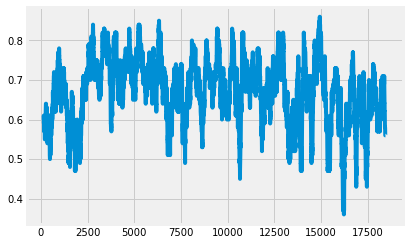

In [711]:
df_plot = df_merge_goals[(df_merge_goals['first_goal']=="home")]
ax = df_plot["winning_team"].rolling(100).mean().plot() 

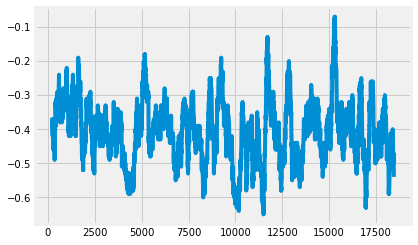

In [712]:
df_plot = df_merge_goals[(df_merge_goals['first_goal']=="away")]

ax = df_plot["winning_team"].rolling(100).mean().plot()

<AxesSubplot:title={'center':'Top 10 teams - HOME'}, xlabel='home'>

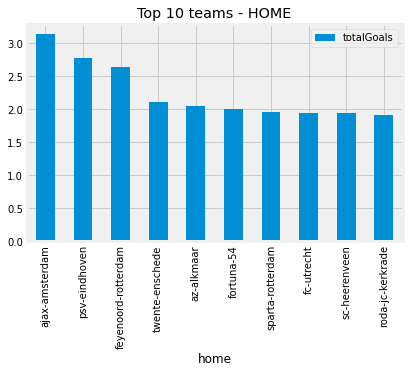

In [713]:
group_home = df_merge_goals.groupby('home').agg(totalGoals = ('home_score', 'mean'))
group_home.sort_values(by=['totalGoals'], inplace=True, ascending=False)
df_plot = pd.DataFrame(group_home['totalGoals'].nlargest(n=10)) 
df_plot.plot(kind="bar", title = "Top 10 teams - HOME")

<AxesSubplot:title={'center':'Top 10 teams - AWAY'}, xlabel='away'>

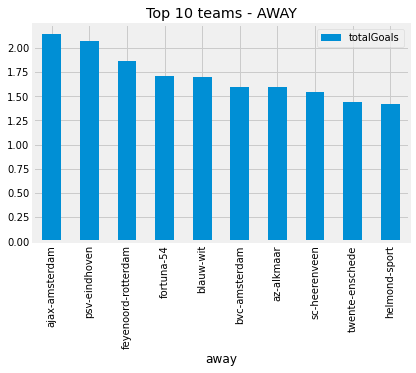

In [714]:
group_away = df_merge_goals.groupby(['away']).agg(totalGoals = ('away_score', 'mean'))
group_away.sort_values(by=['totalGoals'], inplace=True, ascending=False)
df_plot = pd.DataFrame(group_away['totalGoals'].nlargest(n=10)) 
df_plot.plot(kind="bar", title = "Top 10 teams - AWAY")

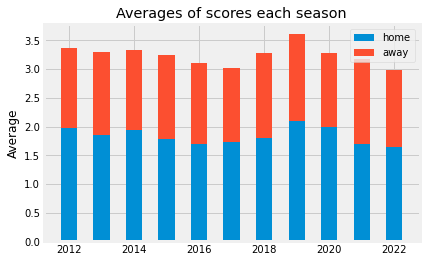

In [715]:
df_last10_season = df_merge_goals[df_merge_goals["season"] >= 2012]

groupBy_season = df_last10_season.groupby('season', as_index=False).agg(home_score_mean = ('home_score', 'mean'),
                                                                        away_score_mean = ('away_score', 'mean'))
labels = groupBy_season['season']
home_means = groupBy_season['home_score_mean']
away_means = groupBy_season['away_score_mean']
width = 0.50    

fig, ax = plt.subplots()

ax.bar(labels, home_means, width, label='home')
ax.bar(labels, away_means, width, bottom=home_means,
       label='away')

ax.set_ylabel('Average')
ax.set_title('Averages of scores each season')
ax.legend()

plt.show()

Text(0, 0.5, 'Averages')

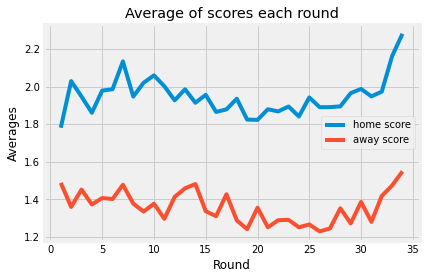

In [716]:
df_filter_round = df_merge_goals[df_merge_goals["round"] <= 34]
groubBy_homeScore_EachRound = df_filter_round.groupby('round', as_index=False).agg(home_score_mean = ('home_score', 'mean'),
                                                                away_score_mean = ('away_score', 'mean'))

plt.plot(groubBy_homeScore_EachRound['round'], groubBy_homeScore_EachRound['home_score_mean'], label="home score")
plt.plot(groubBy_homeScore_EachRound['round'], groubBy_homeScore_EachRound['away_score_mean'], label="away score")
plt.legend()
plt.title("Average of scores each round")
plt.xlabel("Round")
plt.ylabel("Averages")

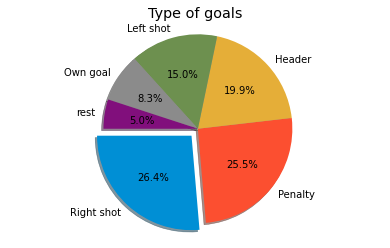

In [717]:
labels = groubBy_typeGoal.index
sizes = groubBy_typeGoal
explode = (0.1, 0, 0, 0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal') 
ax1.set_title("Type of goals")

plt.show()

Text(0, 0.5, 'winning team')

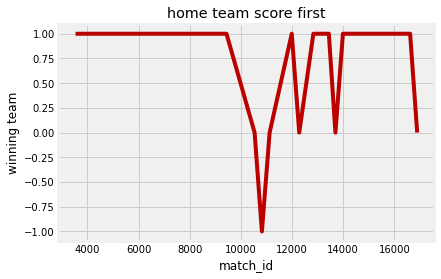

In [718]:
df_plot = pd.DataFrame()
season = df_merge_goals['season']
home = df_merge_goals['home']
away = df_merge_goals['away']
winning_team = df_merge_goals['winning_team']
first_goal = df_merge_goals["first_goal"]
df_plot['season'] = season
df_plot['home'] = home
df_plot['away'] = away
df_plot['winning_team'] = winning_team
df_plot['first_goal'] = first_goal

df_filter_last_game = df_plot[(df_plot['home'] == "fc-utrecht") & (df_plot['away'] == "nec-nijmegen") ]
df_home_team_scoreFirst = df_filter_last_game[df_filter_last_game['first_goal'] == "home"]

ax = df_home_team_scoreFirst["winning_team"].rolling(1).mean().plot(title='home team score first', color = '#BB0000')
ax.set_xlabel("match_id")
ax.set_ylabel("winning team")

Text(0, 0.5, 'winning team')

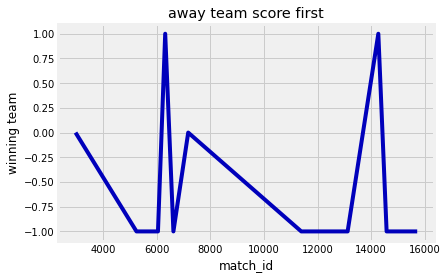

In [719]:
df_away_team_scoreFirst = df_filter_last_game[df_filter_last_game['first_goal'] == "away"]

ax = df_away_team_scoreFirst["winning_team"].rolling(1).mean().plot(title='away team score first', color= "#0000BB")
ax.set_xlabel("match_id")
ax.set_ylabel("winning team")

Text(0, 0.5, 'Averages')

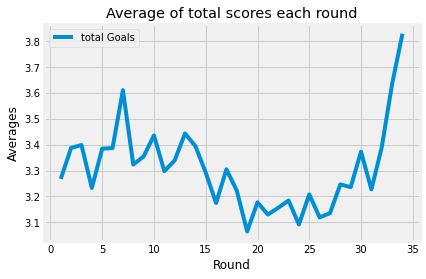

In [720]:
df_filter_round = df_merge_goals[df_merge_goals["round"] <= 34]
groubBy_totalGoals_EachRound = df_filter_round.groupby('round', as_index=False).agg(totalGoals = ('total_goals', 'mean'))

plt.plot(groubBy_totalGoals_EachRound['round'], groubBy_totalGoals_EachRound['totalGoals'], label="total Goals")
plt.legend()
plt.title("Average of total scores each round")
plt.xlabel("Round")
plt.ylabel("Averages")

Text(0, 0.5, 'Averages')

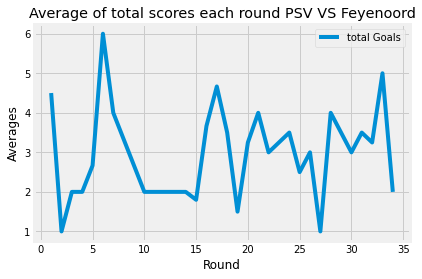

In [721]:
# feyenoord-rotterdam Vs psv-eindhoven in Rotterdam 
df_feyVsPsv_filter_round = df_merge_goals[(df_merge_goals["round"] <= 34) & 
                                          (df_merge_goals["home"] == "feyenoord-rotterdam") & 
                                          (df_merge_goals["away"] == "psv-eindhoven")]
                                          
groubBy_feyVsPsv_totalGoals_EachRound = df_feyVsPsv_filter_round.groupby('round', as_index=False).agg(totalGoals = ('total_goals', 'mean'))

plt.plot(groubBy_feyVsPsv_totalGoals_EachRound['round'], groubBy_feyVsPsv_totalGoals_EachRound['totalGoals'], label="total Goals")
plt.legend()
plt.title("Average of total scores each round PSV VS Feyenoord")
plt.xlabel("Round")
plt.ylabel("Averages")

Text(0, 0.5, 'Averages')

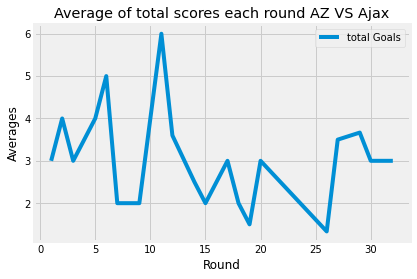

In [722]:
# AZ Alkamaar Vs ajax-amsterdam in Alkamaar 
df_AzVsAjax_filter_round = df_merge_goals[(df_merge_goals["round"] <= 34) & 
                                          (df_merge_goals["home"] == "az-alkmaar") & 
                                          (df_merge_goals["away"] == "ajax-amsterdam")]
                                          
groubBy_AzVsAjax_totalGoals_EachRound = df_AzVsAjax_filter_round.groupby('round', as_index=False).agg(totalGoals = ('total_goals', 'mean'))

plt.plot(groubBy_AzVsAjax_totalGoals_EachRound['round'], groubBy_AzVsAjax_totalGoals_EachRound['totalGoals'], label="total Goals")
plt.legend()
plt.title("Average of total scores each round AZ VS Ajax")
plt.xlabel("Round")
plt.ylabel("Averages")

### 2

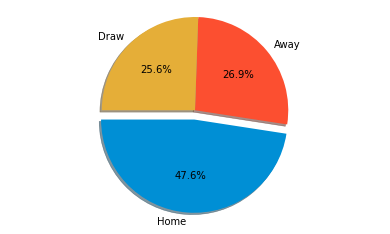

In [723]:
WinningHomeTeamFilter = df_matches[ (df_matches['home_score'] > df_matches['away_score'])]
WinningAwayTeamFilter = df_matches[ (df_matches['home_score'] < df_matches['away_score'])]
DrawTeamFilter = df_matches[ (df_matches['home_score'] == df_matches['away_score'])]

labels = ["Home", "Away", "Draw"]
sizes = [len(WinningHomeTeamFilter.index), len(WinningAwayTeamFilter.index),len(DrawTeamFilter.index) ]
explode = (0.1, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal') 

plt.show()

Text(0, 0.5, 'Averages')

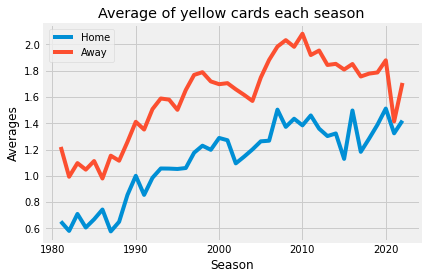

In [724]:
groubBy_yellow_card_EachSeason = df_test.groupby('season', as_index=False).agg(yellowCardHome = ('yellowCardHome', 'mean'),
                                                                yellowCardAway = ('yellowCardAway', 'mean'))

plt.plot(groubBy_yellow_card_EachSeason['season'], groubBy_yellow_card_EachSeason['yellowCardHome'], label="Home")
plt.plot(groubBy_yellow_card_EachSeason['season'], groubBy_yellow_card_EachSeason['yellowCardAway'], label="Away")
plt.legend()
plt.title("Average of yellow cards each season")
plt.xlabel("Season")
plt.ylabel("Averages")

Text(0, 0.5, 'Averages')

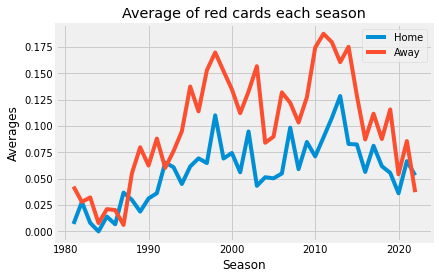

In [725]:
groubBy_red_card_EachSeason = df_test.groupby('season', as_index=False).agg(redCardHome = ('redCardHome', 'mean'),
                                                                redCardAway = ('redCardAway', 'mean'))

plt.plot(groubBy_red_card_EachSeason['season'], groubBy_red_card_EachSeason['redCardHome'], label="Home")
plt.plot(groubBy_red_card_EachSeason['season'], groubBy_red_card_EachSeason['redCardAway'], label="Away")
plt.legend()
plt.title("Average of red cards each season")
plt.xlabel("Season")
plt.ylabel("Averages")

Text(0, 0.5, 'Averages')

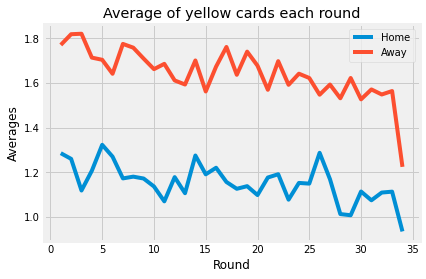

In [726]:
df_filter_round = df_test[df_test['round'] <= 34]
groubBy_yellow_card_EachRound = df_filter_round.groupby('round', as_index=False).agg(yellowCardHome = ('yellowCardHome', 'mean'),
                                                                yellowCardAway = ('yellowCardAway', 'mean'))

plt.plot(groubBy_yellow_card_EachRound['round'], groubBy_yellow_card_EachRound['yellowCardHome'], label="Home")
plt.plot(groubBy_yellow_card_EachRound['round'], groubBy_yellow_card_EachRound['yellowCardAway'], label="Away")
plt.legend()
plt.title("Average of yellow cards each round")
plt.xlabel("Round")
plt.ylabel("Averages")

Text(0, 0.5, 'Averages')

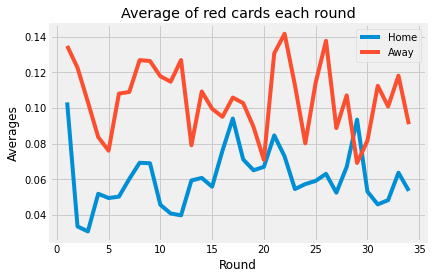

In [727]:
groubBy_red_card_EachRound = df_filter_round.groupby('round', as_index=False).agg(redCardHome = ('redCardHome', 'mean'),
                                                                redCardAway = ('redCardAway', 'mean'))

plt.plot(groubBy_red_card_EachRound['round'], groubBy_red_card_EachRound['redCardHome'], label="Home")
plt.plot(groubBy_red_card_EachRound['round'], groubBy_red_card_EachRound['redCardAway'], label="Away")
plt.legend()
plt.title("Average of red cards each round")
plt.xlabel("Round")
plt.ylabel("Averages")

In [728]:
groubBy_red_cardHome = df_test.groupby('redCardHome', as_index=False).agg(winning_team = ('winning_team', 'mean'))
groubBy_red_cardHome

,redCardHome,winning_team
0,0,0.205520
1,1,-0.157895
2,2,-0.523810


In [729]:
groubBy_red_cardHome = df_test.groupby('redCardHome', as_index=False).agg(winning_team = ('winning_team', 'mean'))
groubBy_red_cardHome

,redCardHome,winning_team
0,0,0.205520
1,1,-0.157895
2,2,-0.523810


## Machine Learning

### Predict which team is more likely to score the first goal.

In [730]:
df_prediction = pd.DataFrame()
season = df_merge_goals["season"]
round =  df_merge_goals["round"]
home =  df_merge_goals["home"]
away = df_merge_goals["away"]
first_goal = df_merge_goals["first_goal"]
home_score = df_merge_goals["home_score"]
away_score = df_merge_goals["away_score"]
winning_team = df_merge_goals["winning_team"]

df_prediction['season'] = season
df_prediction['round'] = round
df_prediction['home'] = home
df_prediction['away'] = away
df_prediction["first_goal"] = first_goal
df_prediction['home_score'] = home_score
df_prediction['away_score'] = away_score
df_prediction["winning_team"] = winning_team
df_prediction["total_goals"] = home_score + away_score

In [731]:
ids = label.fit_transform(raw_goals_file['home'])
mappingHome = dict(zip(label.classes_, range(len(label.classes_))))

In [732]:
ids = label.fit_transform(df_merge_goals['home'])
mappingHome = dict(zip(label.classes_, range(len(label.classes_))))

df_prediction["home"] = label.fit_transform(df_prediction['home'])
df_prediction["away"] = label.fit_transform(df_prediction['away'])

In [733]:
X = df_prediction[["home","away"]]
y = df_prediction["first_goal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [734]:
clf = tree.DecisionTreeClassifier()

clf.fit(X_train,y_train)

clf.score(X_test,y_test)

0.5998915695310382

#### PEC Zwolle Vs FC Utrecht in Zwolle - first goal

In [735]:
# 0 away scores first 
# 1 home scores first
clf.predict([[31, 16]])

array(['home'], dtype=object)

#### AZ Alkamaar Vs Ajax-amsterdam in Alkamaar 

In [736]:
clf.predict([[3, 2]])

array(['away'], dtype=object)

#### Feyenoord-rotterdam Vs PSV-Eindhoven in Alkamaar 

In [737]:
clf.predict([[19, 32]]) 

array(['home'], dtype=object)

### Predict how many red cards can the away team get in a match.

In [738]:
ids = label.fit_transform(df_test['away_score'])
mappingHome = dict(zip(label.classes_, range(len(label.classes_))))

In [739]:
ids = label.fit_transform(df_test['home'])
mappingHome = dict(zip(label.classes_, range(len(label.classes_))))

df_test["home"] = label.fit_transform(df_test['home'])
df_test["away"] = label.fit_transform(df_test['away'])

In [740]:
X = df_test[["home","away"]]
y = df_test[["redCardAway"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [741]:
winning_team = tree.DecisionTreeClassifier()
winning_team.fit(X_train,y_train)

winning_team.score(X_test,y_test)

0.8840749414519906

In [742]:
winning_team.predict([[6, 5]])

array([0], dtype=int64)

In [743]:
df_Cards_prediction = pd.DataFrame()
HomeTeam = df_cards['home']
AwayTeam = df_cards['away']
typeCards = df_cards['type']
team_has_card = df_cards['team']

df_Cards_prediction['home_team'] = HomeTeam
df_Cards_prediction['away_team'] = AwayTeam
df_Cards_prediction['type_card'] = typeCards
df_Cards_prediction['team_has_card'] = team_has_card
df_Cards_prediction["home_team_nr"] = label.fit_transform(df_Cards_prediction['home_team'])
df_Cards_prediction["away_team_nr"] = label.fit_transform(df_Cards_prediction['away_team'])
df_Cards_prediction["type_card"].replace({"red-card": 1, "yellow-card": 0}, inplace=True)

In [744]:
X = df_Cards_prediction[["home_team_nr","away_team_nr","type_card"]]
y = df_Cards_prediction["team_has_card"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [745]:
more_likely_Card = tree.DecisionTreeClassifier()
more_likely_Card.fit(X_train,y_train)

more_likely_Card.score(X_test,y_test)

0.5610734114743985

In [746]:
more_likely_Card.predict([[27 , 1, 1]])

array(['ajax-amsterdam'], dtype=object)

### Predict winning team

In [747]:
X1 = df_prediction[["home","away"]]
y1 = df_prediction["winning_team"]

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.20, random_state=1)

In [748]:
clf1 = tree.DecisionTreeClassifier()

clf1.fit(X_train,y_train)

clf1.score(X_test,y_test)

0.5155868799132556

In [749]:
clf1.predict([[31, 16]]) # PEC Zwolle Vs FC Utrecht in zwolle 

array([0], dtype=int64)

In [750]:
clf1.predict([[3, 2]]) # AZ Alkamaar Vs ajax-amsterdam in Alkamaar 

array([-1], dtype=int64)

In [751]:
clf1.predict([[19, 32]]) # feyenoord-rotterdam Vs psv-eindhoven in Rotterdam 

array([1], dtype=int64)

### Predict total goals


In [752]:
X2 = df_prediction[["home","away"]]
y2 = df_prediction["total_goals"]
reg = LinearRegression().fit(X2, y2)
acc= reg.score(X2, y2)
print(acc)
coe = reg.coef_
inter = reg.intercept_
reg.predict([[31, 16]])

0.0013138929448867076


array([3.30104225])

#### Feyenoord-Rotterdam Vs PSV-Eindhoven in Rotterdam 

In [755]:
reg.predict([[19, 32]]) 

array([3.30743111])

In [756]:
inter

3.461150637072264